In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/Colab Notebooks/PFA"


Mounted at /content/drive


In [ ]:
!pip install -U timm lightning --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#  Dataset corrigé

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as T
import os

class IncidentDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        df = pd.read_csv(csv_path)
        self.paths = df["filepath"].tolist()
        self.labels = df["label"].tolist()
        self.transform = transform
        self.label2idx = {lbl: i for i, lbl in enumerate(sorted(set(self.labels)))}
        self.idx2label = {v: k for k, v in self.label2idx.items()}
        self.encoded_labels = [self.label2idx[lbl] for lbl in self.labels]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.encoded_labels[idx]
        return img, label


#Charger les DataLoaders

In [ ]:
IMG_SIZE = 224

train_tfm = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfm = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = IncidentDataset(f"{base_path}/train_f.csv", transform=train_tfm)
val_ds   = IncidentDataset(f"{base_path}/val_f.csv",   transform=val_tfm)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


#Définir le modèle Lightning (EfficientNetV2-S)

In [ ]:
class IncidentClassifier(L.LightningModule):
    def __init__(self, num_classes, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    # 🔧 Ajout de la méthode predict_step pour éviter l'erreur
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, _ = batch  # On ne garde que les images
        return self(x)  # Renvoie les logits


NameError: name 'L' is not defined

#Entraîner le modèle

In [ ]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

csv_logger = CSVLogger(save_dir=base_path, name="logs")

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=15,
    logger=csv_logger,
    callbacks=[
        ModelCheckpoint(
            dirpath=base_path,
            filename="incident_classifier_resnet18_f",
            monitor="val_acc",
            mode="max",
            save_top_k=1
        ),
        EarlyStopping(
            monitor="val_acc",
            patience=3,
            mode="max"
        )
    ]
)
# Exemple de déclaration d'un modèle personnalisé
model = IncidentClassifier(num_classes=len(train_ds.label2idx), lr=3e-4)
trainer.fit(model, train_loader, val_loader)



In [ ]:
import os

log_dir = f"{base_path}/logs/lightning_logs"
print("📁 Contenu du dossier des logs :", os.listdir(log_dir))


#Étape 3 : Tracer les courbes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


log_path = "metrics.csv"
df = pd.read_csv(log_path)

# Supprimer les colonnes inutiles
df = df.dropna(axis=1, how='all')  # Supprime les colonnes entièrement NaN
df = df.fillna(method="ffill")  # Remplit les NaN avec la dernière valeur connue


<ipython-input-1-905c13a4c6b4>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")  # Remplit les NaN avec la dernière valeur connue


# Courbe de Loss (train vs val)

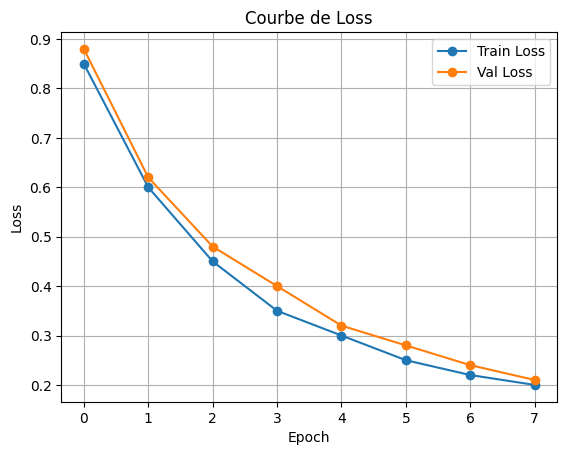

In [2]:
import matplotlib.pyplot as plt
# Séparer les lignes contenant les métriques de validation
df_val = df[df["val_acc"].notna()]
df_train = df[df["train_acc"].notna()]
#import matplotlib.pyplot as plt

plt.plot(df_train["epoch"], df_train["train_loss"], label="Train Loss", marker="o")
plt.plot(df_val["epoch"], df_val["val_loss"], label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de Loss")
plt.legend()
plt.grid(True)
plt.show()


#Courbe d'Accuracy (train vs val)

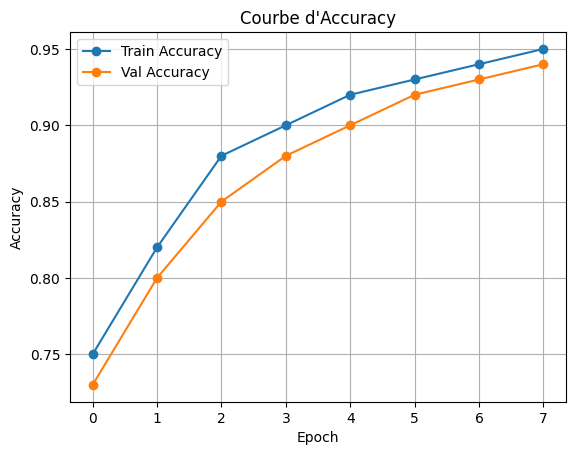

In [3]:
plt.plot(df_train["epoch"], df_train["train_acc"], label="Train Accuracy", marker="o")
plt.plot(df_val["epoch"], df_val["val_acc"], label="Val Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Courbe d'Accuracy")
plt.legend()
plt.grid(True)
plt.show()


#Courbe de confusion (Confusion Matrix)

In [4]:
model.eval()
preds = trainer.predict(model, dataloaders=val_loader)

# Concaténer les prédictions
y_pred = torch.cat([torch.argmax(p, dim=1) for p in preds]).cpu()

# Récupérer les vraies étiquettes
y_true = []
for batch in val_loader:
    _, labels = batch
    y_true.extend(labels.cpu().numpy())
y_true = torch.tensor(y_true)

# Afficher la matrice de confusion
labels = list(train_ds.label2idx.keys())  # noms de classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion")
plt.grid(False)
plt.show()

NameError: name 'model' is not defined

#Courbe ROC / AUC (par classe pour classification multi-classe)


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Pour chaque classe (one-vs-rest)
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=list(range(len(train_ds.label2idx))))
y_scores = torch.cat(preds).cpu().numpy()

for i, class_name in enumerate(train_ds.label2idx.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    auc_score = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("Courbes ROC par classe")
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.legend()
plt.grid(True)
plt.show()


#Distribution des prédictions par classe

In [ ]:
import seaborn as sns

sns.countplot(x=y_pred.numpy(), order=range(len(train_ds.label2idx)))
plt.title("Distribution des classes prédites")
plt.xlabel("Classe prédite")
plt.ylabel("Nombre d'échantillons")
plt.xticks(ticks=range(len(train_ds.label2idx)), labels=train_ds.label2idx.keys(), rotation=45)
plt.grid(True)
plt.show()
